In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 1. Data Overview

Reference Paper:    
Kather, Jakob Nikolas, et al. "Predicting survival from colorectal cancer histology slides using deep learning: A retrospective multicenter study." PLoS medicine 16.1 (2019): e1002730.

In [2]:
data = np.load('../datasets/pathmnist.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [3]:
x_train = data['train_images']
x_test = data['test_images']
x_val = data['val_images']

y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

In [4]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (89996, 28, 28, 3)
Shape of y_train: (89996, 1)
Shape of x_test: (7180, 28, 28, 3)
Shape of y_test: (7180, 1)
Shape of x_val: (10004, 28, 28, 3)
Shape of y_val: (10004, 1)


 The shapes indicate that the images have dimensions of 28x28 pixels, and this is a RGB image with 3 color channels.

In [5]:
unique_classes = np.unique(y_train)
print('The number of classes:', len(unique_classes))

The number of classes: 9


Class names:   
- ADI, adipose tissue;   
- BACK, background;   
- CRC, colorectal cancer;   
- DEB, debris;   
- HE, hematoxylin–eosin;    
- LYM, lymphocytes;    
- MUC, mucus;   
- MUS, smooth muscle; 
- NCT, National Center for Tumor Diseases; 
- NORM, normal colon mucosa;   
- STR, cancer-associated stroma;   
- TUM, colorectal adenocarcinoma epithelium.

In [6]:
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [7]:
class_data = {class_label: [] for class_label in unique_classes}
for class_label in unique_classes:
    class_idx = np.where(y_train == class_label)[0]
    class_data[class_label] = x_train[class_idx]

In [8]:
# Display the number of samples in each class
for class_label, class_samples in class_data.items():
    print(f"{class_names[class_label]}: {len(class_samples)} samples")

ADI: 9366 samples
BACK: 9509 samples
DEB: 10360 samples
LYM: 10401 samples
MUC: 8006 samples
MUS: 12182 samples
NORM: 7886 samples
STR: 9401 samples
TUM: 12885 samples


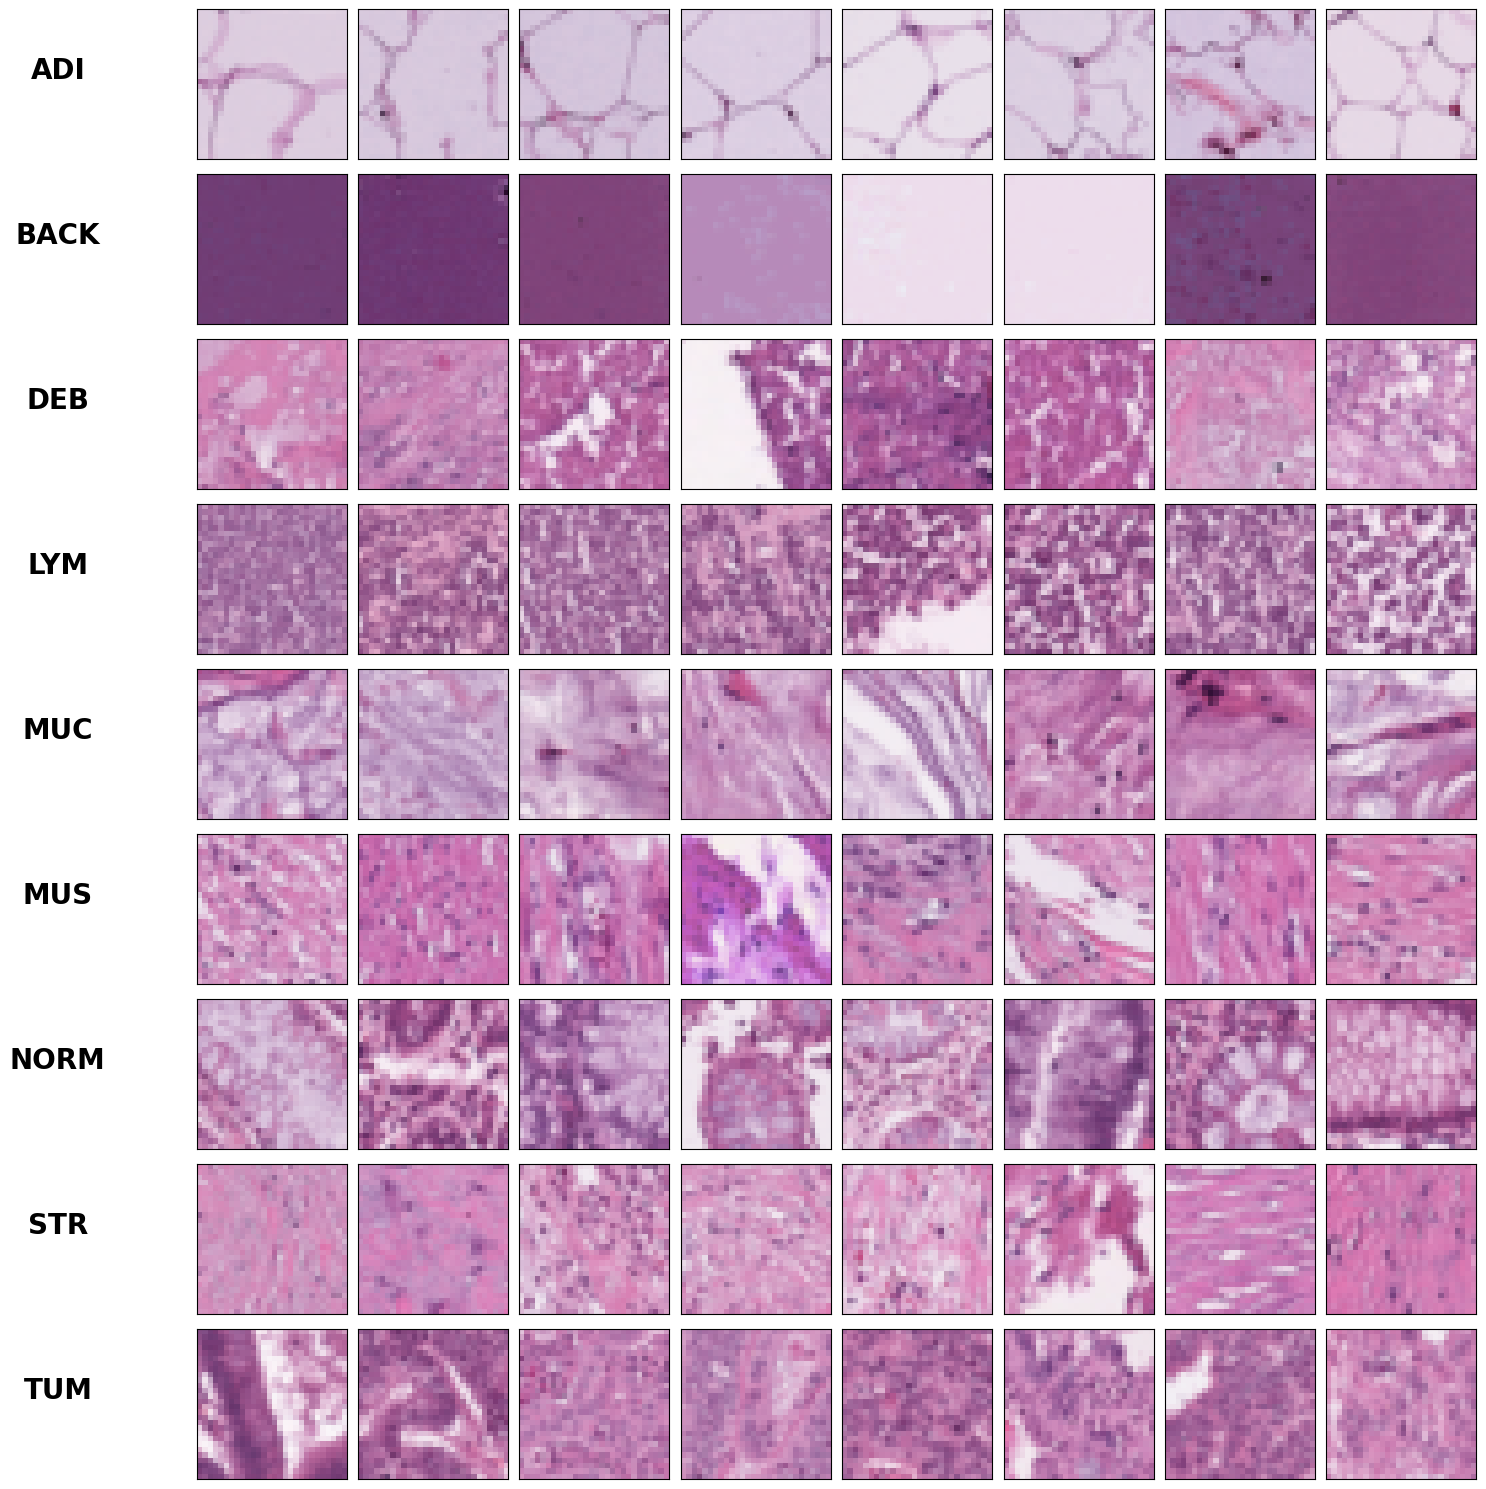

In [9]:
def imagedisplay(class_data, class_names, num_images_per_class):
    fig = plt.figure(figsize=(15, 15))
    
    for i, (class_label, class_samples) in enumerate(class_data.items()):
        np.random.shuffle(class_samples)
        class_samples = class_samples[:num_images_per_class]
        
        for j, img_data in enumerate(class_samples):
            fig.add_subplot(len(class_names), num_images_per_class, i * num_images_per_class + j + 1, 
                             xticks=[], yticks=[])
            
            plt.imshow(img_data)
            
            if j == 0:
                plt.ylabel(class_names[i], rotation=0, labelpad=100, fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

imagedisplay(class_data, class_names, 8)


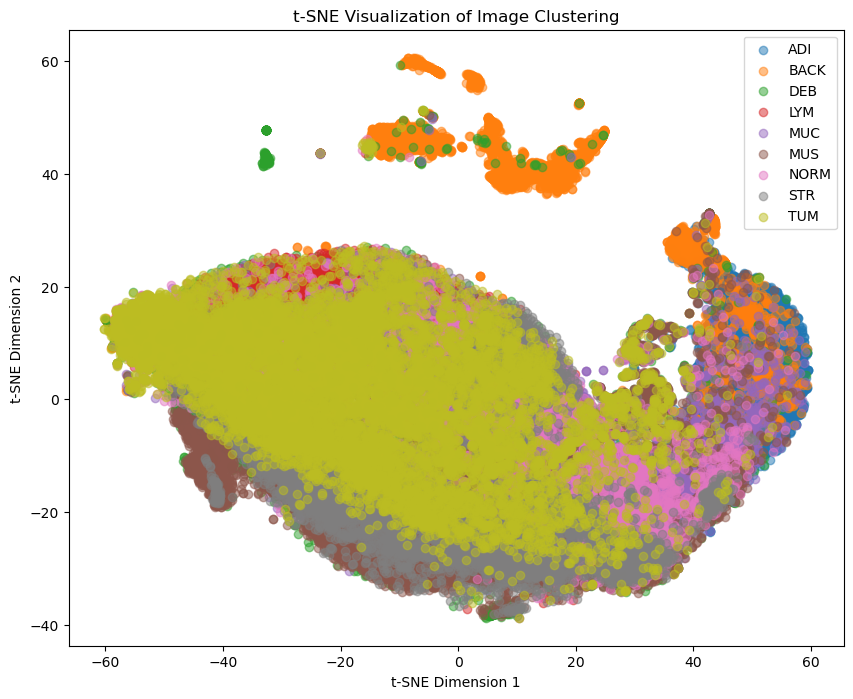

In [65]:
def visualize_tsne(image_data, labels, class_names):
    # Flatten image data if needed
    image_data_flatten = image_data.reshape(image_data.shape[0], -1)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(image_data_flatten)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        plt.scatter(tsne_result[class_indices, 0], tsne_result[class_indices, 1], label=class_name, alpha=0.5)

    plt.title("t-SNE Visualization of Image Clustering")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

visualize_tsne(x_train, y_train, class_names)
#running 13min


## Data Preprocessing

In [9]:
x_train1 = np.array(x_train)/255
x_test1 = np.array(x_test)/255
x_val1 = np.array(x_val)/255
print(x_train1.shape)

(89996, 28, 28, 3)


In [30]:
x_train_flat = x_train1.reshape(x_train1.shape[0], -1)
x_test_flat = x_test1.reshape(x_test1.shape[0], -1)
x_val_flat =x_val.reshape(x_val1.shape[0], -1)
print(x_train_flat.shape)

(89996, 2352)


In [21]:
# Flatten image: converting a multi-dimensional array (like an image) into a one-dimensional array. 
img_size = 28
x_train_flat = x_train.reshape(-1, img_size*img_size)
x_val_flat = x_val.reshape(-1, img_size* img_size)
x_test_flat = x_test.reshape(-1, img_size*img_size)
print(x_train_flat.shape)

(269988, 784)
(89996, 28, 28, 3)


In [14]:
# Normalization, min-max == /255
scaler1 = MinMaxScaler()
x_train_scaled_minmax = scaler1.fit_transform(x_train_flat)
x_test_scaled_minmax = scaler1.fit_transform(x_test_flat)
x_val_scaled_minmax = scaler1.fit_transform(x_val_flat)
print(x_train_scaled_minmax.shape)

(269988, 784)


In [15]:
# normalization, Standardize
scaler2 = StandardScaler()
x_train_flat_scaled_std = scaler2.fit_transform(x_train_flat)
x_test_flat_scaled_std = scaler2.fit_transform(x_test_flat)
x_val_flat_scaled_std = scaler2.transform(x_val_flat)
print(x_train_flat_scaled_std.shape)

(269988, 784)


In [16]:
y_train_flat = np.array(y_train).ravel()
y_val_flat = np.array(y_val).ravel()
y_test_flat = np.array(y_test).ravel()
print(y_train.shape)
print(y_train_flat.shape)

(89996, 1)
(89996,)


In [ ]:
## Reshape the flattened images back to the original shape
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)
x_val_reshaped= x_val.reshape(x_val.shape[0], -1)

In [15]:
# for CNN
x_train1 = x_train.reshape(-1, img_size, img_size, 1)
x_val1 = x_val.reshape(-1, img_size, img_size, 1)
x_test3 = x_test.reshape(-1, img_size, img_size, 1)

Data Augmentation

In [18]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,    # apply ZCA whitening
        rotation_range = 30,    # random rotation in the range 0 to 180 degrees
        zoom_range = 0.2,       # random zoom  
        width_shift_range=0.1,  # random horizontal shift  (fraction of total width)
        height_shift_range=0.1,  # random vertical shift   (fraction of total height)
        horizontal_flip = True,  # random horizontal flip 
        vertical_flip=False)  # random vertical flip 

## 3. Model Training

### KNN

In [18]:
# x_train1, x_test1(/255), y_train
def knn_classification(x_train, y_train, x_test, y_test, n_neighbors=9):

    # Reshape the data, (89996, 28, 28, 3)-->(89996, 2352)
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(x_train_flat, y_train.ravel())
    predictions = knn_classifier.predict(x_test_flat)

    # Evaluate the performance
    accuracy = accuracy_score(y_test.ravel(), predictions)
    classification_rep = classification_report(y_test.ravel(), predictions)
    confusion_mat = confusion_matrix(y_test.ravel(), predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat

In [19]:
accuracy, classification_rep, confusion_mat = knn_classification(x_train1, y_train, x_test1, y_test)

Accuracy: 35.82%

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77      1338
           1       0.22      1.00      0.36       847
           2       0.24      0.93      0.38       339
           3       0.00      0.00      0.00       634
           4       0.10      0.01      0.02      1035
           5       0.30      0.14      0.19       592
           6       0.21      0.01      0.01       741
           7       0.00      0.00      0.00       421
           8       0.80      0.34      0.47      1233

    accuracy                           0.36      7180
   macro avg       0.31      0.34      0.24      7180
weighted avg       0.41      0.36      0.30      7180


Confusion Matrix:
 [[893 424   1   0   3  13   0   0   4]
 [  0 847   0   0   0   0   0   0   0]
 [  0   7 316   0   0  15   0   1   0]
 [  1 623   3   0   0   1   0   0   6]
 [ 60 952   3   0  12   3   1   0   4]
 [  0  10 494   0   1  85   0   1   1]

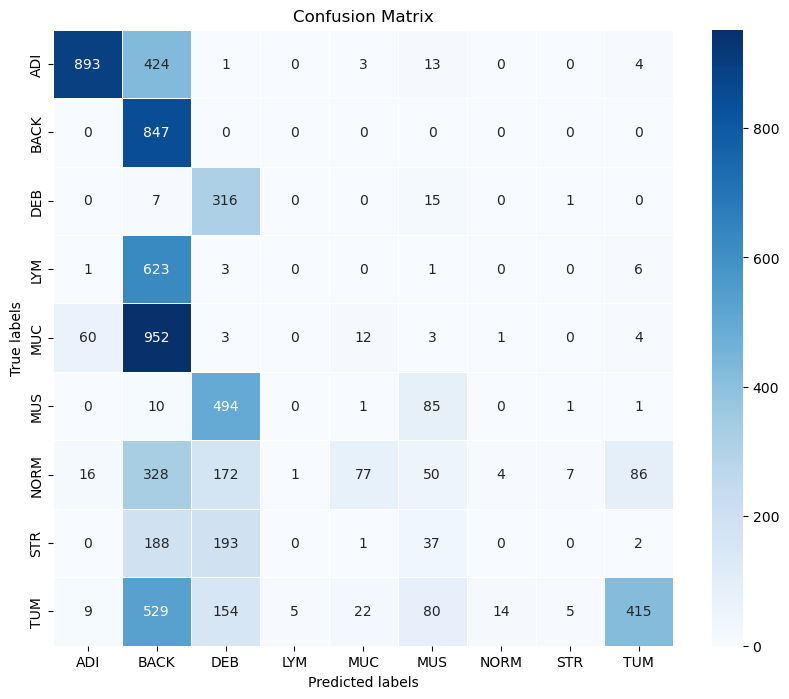

In [21]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g', linewidths=.5, annot_kws={"size": 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### SVM

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

def svm_classification(x_train, y_train, x_test, y_test, kernel='rbf', C=1.0, gamma='scale'):
    """
    Parameters:
    - x_train: Training data features
    - y_train: Training data labels
    - x_test: Testing data features
    - y_test: Testing data labels
    - kernel: Kernel type (default is 'rbf')
    - C: Regularization parameter (default is 1.0)
    - gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' (default is 'scale')

    Returns:
    - accuracy: Accuracy of the classifier on the test set
    - classification_rep: Classification report
    - confusion_mat: Confusion matrix
    """
    # Flatten and scale the data
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)

    # Set the parameters for grid search
    param_grid = {'C': [5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4], 'gamma': ['auto']}

    # Initialize the SVM classifier with GridSearchCV
    clf = GridSearchCV(SVC(kernel=kernel), param_grid, cv=2, verbose=3)

    # Train the classifier
    clf.fit(x_train_scaled, y_train.ravel())

    # Make predictions on the test set
    predictions = clf.predict(x_test_scaled)

    # Get the best parameters found by grid search
    best_params = clf.best_params_
    print("Best parameters found by grid search:")
    print(best_params)

    # Evaluate the performance
    accuracy = accuracy_score(y_test.ravel(), predictions)
    classification_rep = classification_report(y_test.ravel(), predictions)
    confusion_mat = confusion_matrix(y_test.ravel(), predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat, best_params


In [12]:
accuracy, classification_rep, confusion_mat = svm_classification(x_train1, y_train, x_test1, y_test)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .................C=5.0, gamma=auto;, score=0.687 total time=67.3min
[CV 2/2] END .................C=5.0, gamma=auto;, score=0.688 total time=65.9min
[CV 1/2] END ................C=10.0, gamma=auto;, score=0.683 total time=79.5min
[CV 2/2] END ................C=10.0, gamma=auto;, score=0.686 total time=75.1min
[CV 1/2] END ................C=50.0, gamma=auto;, score=0.673 total time=84.8min
[CV 2/2] END ................C=50.0, gamma=auto;, score=0.676 total time=85.8min
[CV 1/2] END ...............C=100.0, gamma=auto;, score=0.671 total time=87.3min
[CV 2/2] END ...............C=100.0, gamma=auto;, score=0.674 total time=87.6min
[CV 1/2] END ...............C=500.0, gamma=auto;, score=0.671 total time=87.2min
[CV 2/2] END ...............C=500.0, gamma=auto;, score=0.672 total time=87.4min
[CV 1/2] END ..............C=1000.0, gamma=auto;, score=0.671 total time=91.7min
[CV 2/2] END .............C=1000.0, gamma=auto;, 

ValueError: too many values to unpack (expected 3)

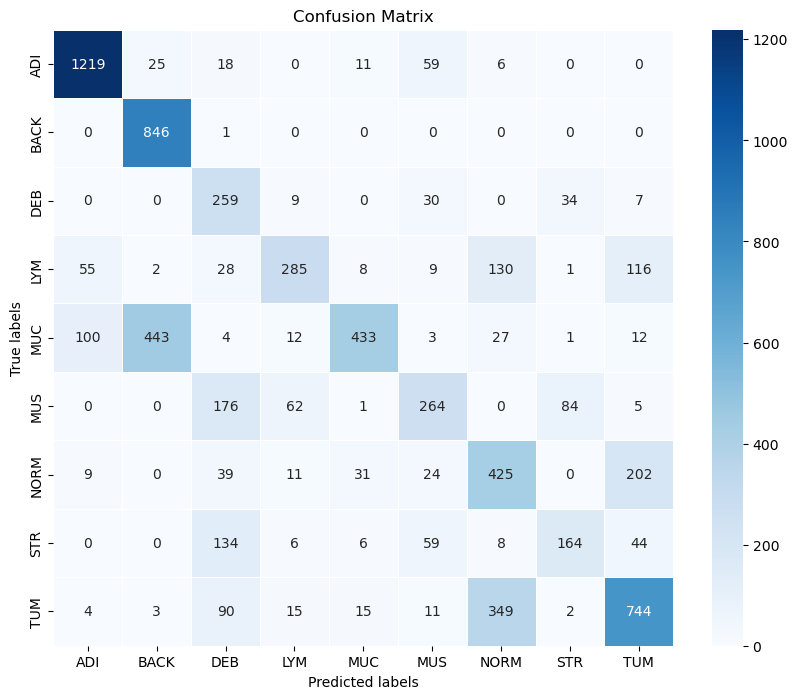

In [23]:
# Given confusion matrix
conf_matrix = np.array([[1219, 25, 18, 0, 11, 59, 6, 0, 0],
                        [0, 846, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 259, 9, 0, 30, 0, 34, 7],
                        [55, 2, 28, 285, 8, 9, 130, 1, 116],
                        [100, 443, 4, 12, 433, 3, 27, 1, 12],
                        [0, 0, 176, 62, 1, 264, 0, 84, 5],
                        [9, 0, 39, 11, 31, 24, 425, 0, 202],
                        [0, 0, 134, 6, 6, 59, 8, 164, 44],
                        [4, 3, 90, 15, 15, 11, 349, 2, 744]])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', linewidths=.5, annot_kws={"size": 10}, xticklabels=class_names, yticklabels = class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
